# XGBoost Model with All Features after initial preprocessing

In [1]:
import pandas as pd
composite_preprocessed = pd.read_csv('Composite_preprocessed_NO_MV_BALANCED.csv')
composite_preprocessed.head()

,Number of Stars,Number of Planets,Number of Moons,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Radial Velocity Time Series,Number of Stellar Spectra Measurements,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements,Circumbinary Flag,Controversial Flag,Discovery Year,Detected by Transits
0,3.094076,-0.666894,0.0,2.424559,1.234306,-0.145901,-0.624689,0.613405,1.731519,-0.261600,-0.012466,-0.044364,0,0,2007,0
1,-0.256668,-0.666894,0.0,1.186720,-0.283545,1.148661,-0.992906,0.613405,0.729626,-0.261600,-0.012466,-0.044364,0,0,2009,0
2,-0.256668,-0.666894,0.0,-0.877523,-0.306068,0.308947,-2.327878,0.613405,0.729626,-0.261600,-0.012466,-0.044364,0,0,2008,0
3,-0.256668,0.216988,0.0,1.382856,-0.669803,0.872499,-0.152934,0.613405,3.735304,0.591749,-0.012466,-0.044364,0,0,2002,0
4,6.444820,-0.666894,0.0,0.261241,-0.531444,1.023143,0.855489,0.613405,3.735304,2.298449,-0.012466,-0.044364,0,0,1996,0


# Train Test Split

In [2]:
# we are trying to predict whether an exoplanet has been detected by transits
targets = composite_preprocessed['Detected by Transits']
# training features are all variables except the targets
features = composite_preprocessed.drop(['Detected by Transits'], axis=1)

## Observe Feature Correlations

In [3]:
features.corr()

,Number of Stars,Number of Planets,Number of Moons,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Radial Velocity Time Series,Number of Stellar Spectra Measurements,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements,Circumbinary Flag,Controversial Flag,Discovery Year
Number of Stars,1.000000,0.109074,NaN,-0.044988,0.104236,-0.087528,-0.069450,0.057734,0.132503,0.077689,-0.003200,-0.002096,0.244685,0.090915,-0.147575
Number of Planets,0.109074,1.000000,NaN,-0.055511,0.008589,0.026680,-0.023926,-0.002505,0.082470,0.186263,0.057797,0.076409,-0.012547,0.061726,-0.072274
Number of Moons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Galactic Latitude [deg],-0.044988,-0.055511,NaN,1.000000,-0.019213,0.463063,0.174632,-0.090369,-0.047292,-0.058085,-0.025691,-0.008918,0.009070,-0.016991,0.031820
Galactic Longitude [deg],0.104236,0.008589,NaN,-0.019213,1.000000,-0.657044,-0.408779,0.131333,0.113682,0.054698,-0.008283,-0.026088,0.025643,0.020641,-0.106558
Ecliptic Latitude [deg],-0.087528,0.026680,NaN,0.463063,-0.657044,1.000000,0.498442,-0.222283,-0.139970,-0.104345,-0.006864,0.025212,-0.028239,-0.013646,0.081113
Ecliptic Longitude [deg],-0.069450,-0.023926,NaN,0.174632,-0.408779,0.498442,1.000000,-0.119612,-0.191094,-0.193637,0.013811,0.031078,0.001673,0.000296,0.058041
Number of Photometry Time Series,0.057734,-0.002505,NaN,-0.090369,0.131333,-0.222283,-0.119612,1.000000,0.174390,0.182466,-0.004172,-0.014848,-0.022719,0.008973,-0.252983
Number of Radial Velocity Time Series,0.132503,0.082470,NaN,-0.047292,0.113682,-0.139970,-0.191094,0.174390,1.000000,0.492154,-0.003394,-0.007912,-0.019551,-0.006469,-0.498031
Number of Stellar Spectra Measurements,0.077689,0.186263,NaN,-0.058085,0.054698,-0.104345,-0.193637,0.182466,0.492154,1.000000,-0.003261,-0.011606,-0.019001,0.020205,-0.244466


## Split data

In [4]:
# Splitting dataset into training and testing addresses overfitting
# shuffling is necessary to remove dependencies that come from order of data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, targets, train_size = 0.8, random_state = 42)

x_train.shape, y_train.shape

((5148, 15), (5148,))

# Fitting the XGBoost Model

In [5]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

xgb_model_all = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')


# XGBoost models can't have [, ] or < characters in feature names
# One or more of these characters are present in our features (ex: Ecliptic Latitude [deg])
# Use lambda to rename features and run the model

x_train_clean = x_train.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace('>', ''))
x_test_clean = x_test.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace('>', ''))

xgb_model_all.fit(x_train_clean, y_train)

/Users/kevin/anaconda3/envs/py310_ds/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

## Predict on the test set

In [6]:
y_pred_xgb_all = xgb_model_all.predict(x_test_clean)

In [13]:
accuracy = accuracy_score(y_test, y_pred_xgb_all)
class_report = classification_report(y_test, y_pred_xgb_all, output_dict = True)

accuracy, class_report

(0.9619565217391305,
 {'0': {'precision': 0.9616564417177914,
   'recall': 0.9631336405529954,
   'f1-score': 0.9623944742900998,
   'support': 651},
  '1': {'precision': 0.9622641509433962,
   'recall': 0.9607535321821036,
   'f1-score': 0.9615082482325215,
   'support': 637},
  'accuracy': 0.9619565217391305,
  'macro avg': {'precision': 0.9619602963305938,
   'recall': 0.9619435863675495,
   'f1-score': 0.9619513612613106,
   'support': 1288},
  'weighted avg': {'precision': 0.9619569935630634,
   'recall': 0.9619565217391305,
   'f1-score': 0.9619561777072758,
   'support': 1288}})

## Create DataFrame table for visual comprehension

In [14]:
# converts the classification report dictionary into a pd df and transposes it to get a more readable format
report_df = pd.DataFrame(class_report).transpose()

accuracy_df = pd.DataFrame({'metric': ['accuracy'], 'value': [accuracy]})
report_df['Accuracy'] = [accuracy if idx == 'accuracy' else None for idx in report_df.index]

report_df

,precision,recall,f1-score,support,Accuracy
0,0.961656,0.963134,0.962394,651.000000,NaN
1,0.962264,0.960754,0.961508,637.000000,NaN
accuracy,0.961957,0.961957,0.961957,0.961957,0.961957
macro avg,0.961960,0.961944,0.961951,1288.000000,NaN
weighted avg,0.961957,0.961957,0.961956,1288.000000,NaN


## ROC AUC score 

In [8]:
y_prob_xgb_all = xgb_model_all.predict_proba(x_test_clean)[:,1]
roc_auc_xgb_all = roc_auc_score(y_test, y_prob_xgb_all)

('ROC AUC Score All Features:', roc_auc_xgb_all)

('ROC AUC Score All Features:', 0.9868563518991432)

## Feature Importance Table
### (Importance type = weight)

In [17]:
importance_type = 'weight'

# extract importance of type weight from the xgb model 
feature_importances = xgb_model_all.get_booster().get_score(importance_type = importance_type) 

# extract feature names
feature_names = x_train.columns


# create pd df with the extracted information and sort features by importance (type =  weight)
feature_importance_df = pd.DataFrame(list(feature_importances.items()), columns = ['Features', 'Importance']).sort_values(by='Importance', ascending=False)

feature_importance_df

,Features,Importance
4,Ecliptic Latitude deg,419.0
2,Galactic Latitude deg,357.0
3,Galactic Longitude deg,353.0
5,Ecliptic Longitude deg,350.0
11,Discovery Year,185.0
1,Number of Planets,101.0
6,Number of Photometry Time Series,38.0
0,Number of Stars,26.0
7,Number of Radial Velocity Time Series,17.0
8,Number of Stellar Spectra Measurements,14.0


## Plot Feature Importance

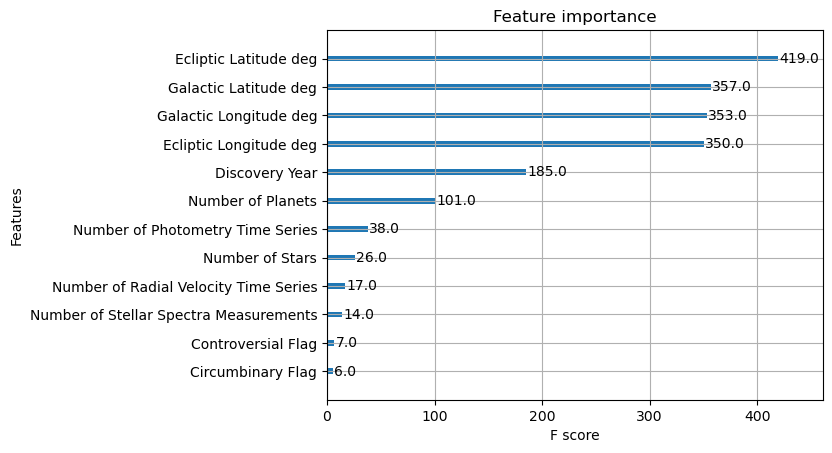

In [9]:
xgb.plot_importance(xgb_model_all)
plt.show()

## F Score (weight) in this context represents the frequency in which a feature is used in the splits of the trees across the entire ensemble
### Frequency refers to the number of times a feature is used to split the data across all trees in the model
### Higher F score means a feature is used more frequently to create decision points (splits) in the trees, indicating the feature is considered important by the model

## Based on the table and plot, an F score threshold of 20 is appropriate 
### We will exclude features that scored less than 20 in the refined features XGBoost training to retain only the most significant features and reduce overall complexity
## Features to Keep:
### Ecliptic Latitude deg (419)
### Galactic Latitude deg (357)
### Galactic Longitude deg (353)
### Ecliptic Longitude deg (350)
### Discovery Year (185)
### Number of Planets (101)
### Number of Photometry Time Series (38)
### Number of Stars (26)
## Features to Exclude:
### Number of Radial Velocity Time Series (17)
### Number of Stellar Spectra Measurements (14)
### Controversial Flag (7)
### Circumbinary Flag (6)